In [ ]:
!pip install pyspellchecker

In [38]:
import torch.nn as nn
import torch
import pandas as pd
from gensim import models
import gensim.downloader as api
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from spellchecker import SpellChecker

In [39]:
augmented_data = pd.read_csv('./drive/My Drive/Augmented_Data2.csv')

In [40]:
augmented_data[augmented_data['Topic']=='Project']

,Text Command,Topic,Identifier,Action,One Hot Encoded Topic,One Hot Encoded Action,Verb/Noun
0,see Developing editorial calendar for content ...,Project,Developing editorial calendar for content sharing,Completed,"[1,0]","[0,0,0,0,1]",SYNREPLACED
1,Developing editorial calendar for content shar...,Project,Developing editorial calendar for content sharing,Create,"[0,1]","[1,0,0,0,0]",SYNREPLACED
2,out of use Developing editorial calendar for c...,Project,Developing editorial calendar for content sharing,Danger,"[0,1]","[0,0,0,1,0]",SYNREPLACED
3,added project Developing editorial calendar fo...,Project,Developing editorial calendar for content sharing,Create,"[0,1]","[1,0,0,0,0]",add
5,Developing editorial calendar for content shar...,Project,Developing editorial calendar for content sharing,On Target,"[0,1]","[0,1,0,0,0]",SYNREPLACED
...,...,...,...,...,...,...,...
5182,Reviewing website backlinks cast on target,Project,Reviewing website backlinks,On Target,"[0,1]","[0,1,0,0,0]",SYNREPLACED
5183,stop Reviewing website backlinks plan,Project,Reviewing website backlinks,Danger,"[0,1]","[0,0,0,1,0]",SYNREPLACED
5185,concluding Reviewing website backlinks plan,Project,Reviewing website backlinks,Completed,"[1,0]","[0,0,0,0,1]",SYNREPLACED
5186,throw Reviewing website backlinks is late,Project,Reviewing website backlinks,At Risk,"[0,1]","[0,0,1,0,0]",SYNREPLACED


In [41]:
#load Google Word2Vec
w = models.KeyedVectors.load_word2vec_format('./drive/My Drive/GoogleNews-vectors-negative300 (1).bin', binary=True)

In [42]:
#words that will not be vectorized
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]  

In [43]:
#function for cleaning sentence by removing grammmar 
def clean_sentence(sentence):
  cleaned_sentence = ''
  for char in sentence:
    if char.isalpha() or char == ' ':
      cleaned_sentence += char
    if char == '-':
      cleaned_sentence += ' '
  return cleaned_sentence

In [48]:
#function for transforming sentence into 2D numerical array 
def vectorize_sentence(sentence,vectorizer,max_len):
  spell_checker = SpellChecker()
  cleaned_sentence = clean_sentence(sentence)
  sentence_lst = cleaned_sentence.split()
  num_words = len(sentence_lst)
  sentence_vector = np.zeros((max_len,300))
  for i in range(num_words):
    word = sentence_lst[i]
    if word not in stopwords:
      try:
        vectorized_word = vectorizer.wv[word]
      except:
        misspelled = spell_checker.unknown([word])
        corrected_word = None
        for word in misspelled:
          corrected_word = spell_checker.correction(word)
        try:
          vectorized_word = vectorizer.wv[corrected_word]
        except:
          vectorized_word = np.zeros(300)
    else:
      #stop word is empty vector of 0s
      vectorized_word = np.zeros(300)
    sentence_vector[i] = vectorized_word
  for j in range(num_words,max_len,1):
    sentence_vector[j] = np.zeros(300)
  return sentence_vector

In [45]:
print(torch.tensor(vectorize_sentence('Done with project data cleaning',w,10)))

tensor([[ 0.0654,  0.2305, -0.2891,  ..., -0.2715, -0.0043,  0.1611],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0181,  0.0085,  0.0698,  ..., -0.1250, -0.0562, -0.1084],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':


In [46]:
#function for changing pandas dataframe from sentences to 2D numerical array
def vectorize_dataset(df, column, filter=None):
  df = df.sample(frac=1).reset_index(drop=True)
  if filter != None:
    df = df.loc[df['Topic'] == filter]
  text_commands = df['Text Command']
  num_rows = len(df.index)
  max_len = max([len(text_commands.loc[i].split()) for i in df.index.values])
  data_vector = np.zeros((num_rows,max_len,300))
  idx = 0
  for i in df.index.values:
    sentence = df.loc[i][0]
    vectorized_sentence = vectorize_sentence(sentence,w,max_len) 
    data_vector[idx] = vectorized_sentence
    idx += 1
  return data_vector, df[column], max_len, text_commands

In [49]:
#load all the data and labels associated with the different use cases
topic_data, topic_labels, topic_max_len, topic_text_commands = vectorize_dataset(augmented_data, 'One Hot Encoded Topic')
task_action_data, task_action_labels, task_action_max_len, task_action_text_commands = vectorize_dataset(augmented_data, 'One Hot Encoded Action', 'Task')
project_action_data, project_action_labels, project_action_max_len, project_action_text_commands = vectorize_dataset(augmented_data, 'One Hot Encoded Action', 'Project')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [50]:
#function for converting the data represented by numpy arrays into tensors
def data_to_tensor(labels,data,array_size):
  labels_tensor = np.zeros((len(labels.index),array_size))
  idx = 0
  for i in (labels.index.values):
    labels_tensor[idx] = np.fromstring(labels.loc[i][1:-1], dtype=np.float64, sep=',') 
    idx += 1
  data_tensor = torch.tensor(data)
  labels_tensor = torch.tensor(labels_tensor)
  return labels_tensor, data_tensor

In [51]:
#convert all the data into tensor format 
topic_labels, topic_data = data_to_tensor(topic_labels,topic_data,2)
task_action_labels, task_action_data = data_to_tensor(task_action_labels,task_action_data,5)
project_action_labels, project_action_data = data_to_tensor(project_action_labels, project_action_data,5)



In [104]:
#LSTM architecture that takes input of vectorized sentences and outputs probability for each topic
class TopicModel(nn.Module):
  def __init__(self):
    super(TopicModel,self).__init__()
    self.lstm = nn.LSTM(300,100,batch_first = True)
    """Change the second parameter according to whether topic or project and task are being trained. 2 is for topic, 5 is for project/task"""
    self.outputtopic = nn.Linear(100,2)
    self.softmax = nn.LogSoftmax(dim=-1)

  def forward(self,x):
    output, (h_n,c_n) = self.lstm(x)
    outputt = self.outputtopic(h_n)
    prob_output = self.softmax(outputt)
    return prob_output



In [105]:
#set feature size of hidden units
hidden_size = 100

#feature dimension of Google Word2Vec word vector(default is 300)
input_size = 300
"""Change this number according to whether topic or project and task are being trained. 2 is for topic, 5 is for project/task"""
#number of topics to predict
num_topics = 2

#set learning rate 
lr = .1

#set training loss metric
loss_metric = nn.NLLLoss()

In [55]:
topic_text_commands,topic_text_commands_raw_text = topic_data, topic_text_commands
project_action_text_commands,project_action_text_commands_raw_text = project_action_data, project_action_text_commands
task_action_text_commands,task_action_text_commands_raw_text = task_action_data, task_action_text_commands


In [56]:
def train(topic_tensor, text_command_tensor):
    model.train()
    #reset the model gradients to 0
    model.zero_grad()
    #predicted label from model
    output = model(text_command_tensor.float())[0]
    idxs = torch.argmax(topic_tensor,dim=-1)
    #calculate negative log likelihood loss from batch of data 
    loss = loss_metric(output, idxs)
    #backpropogate through the model based on NLL loss
    loss.backward()
    #update model parameters using gradients 
    optimizer.step()
    

    return output, loss.item()

In [57]:
#function for testing model on batch of data
def test(model, topic_tensor, text_command_tensor):
  model.eval()
  num_labels = len(topic_tensor[0])
  preds = model(text_command_tensor.float())[0]
  idxs = torch.argmax(topic_tensor[0],dim=-1)
  loss = loss_metric(preds, idxs)
  correct = 0
  for i in range(num_labels):
    pred = preds[i]
    pred_idx = torch.argmax(pred)
    label = topic_tensor[0][i]
    label_idx = torch.argmax(label)
    if pred_idx == label_idx:
      correct += 1
  return ((correct/num_labels), loss)



In [58]:
def predict(model, text_input, wordvec,label2pred):
  model.eval()
  vectorized_sentence = vectorize_sentence(text_input,wordvec,10)
  sentence_tensor = torch.tensor(vectorized_sentence)
  batch_sentence_tensor = torch.unsqueeze(sentence_tensor,0)
  pred = model(batch_sentence_tensor.float())
  return label2pred[int(torch.argmax(pred,dim=-1))]


In [107]:
#Training topic
epochs = 100
#set batch size 
batch_size = 40

# Keep track of losses for plotting
testing_losses = []
testing_accuracies = []
testing_losses = []
for i in range(1):
  current_loss = 0
  all_losses = []
  model = TopicModel()
  optimizer = optim.SGD(model.parameters(), lr=lr)

  idxs = torch.randperm(len(topic_text_commands))
  text_commands = topic_text_commands[idxs]
  labels = topic_labels[idxs]

  training_text_commands,testing_text_commands = text_commands[:4080], text_commands[4080:5100]
  training_labels, testing_labels = labels[:4080], labels[4080:5100]

  #set number of batches
  training_num_batches = int(len(training_text_commands)/batch_size) 

  #reshape text commands and labels to fit training
  training_text_commands = torch.reshape(training_text_commands,(training_num_batches,batch_size,topic_max_len,300))
  training_labels = torch.reshape(training_labels,(training_num_batches,batch_size,num_topics))
  testing_labels = torch.reshape(testing_labels,(1,testing_labels.shape[0],testing_labels.shape[1]))
  training_losses = []
  for iter in range(1, epochs + 1):
    for batch_iter in range(training_num_batches):
      text_batch, label_batch = training_text_commands[batch_iter], training_labels[batch_iter]
      output, loss = train(label_batch, text_batch)
      current_loss += loss

    training_losses.append(current_loss/training_num_batches)

    # Add current loss avg to list of losses
    if iter == epochs:
      testing_accuracy, testing_loss = test(model, testing_labels, testing_text_commands)
      testing_accuracies.append(testing_accuracy)
      testing_losses.append(testing_loss.item())
      all_losses.append(current_loss / training_num_batches)
    current_loss = 0

In [110]:
sum(testing_accuracies)/len(testing_accuracies)

0.9470588235294117

In [109]:
sum(testing_losses)/len(testing_losses)

0.17284752428531647

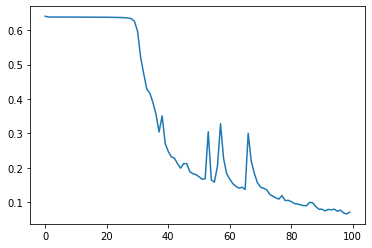

In [108]:
plt.plot(training_losses)

In [ ]:
print(predict(project_action_model,'Finished with project data cleaning',w,{0: 'Create',1: 'On Target',2: 'At Risk',3: 'Danger',4: 'Completed'}))

Completed


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':


In [99]:
#Training project action
epochs = 220
#set batch size 
batch_size = 40

# Keep track of losses for plotting
testing_losses = []
testing_accuracies = []
testing_losses = []
for i in range(1):
  current_loss = 0
  all_losses = []
  model = TopicModel()
  optimizer = optim.SGD(model.parameters(), lr=lr)

  idxs = torch.randperm(len(project_action_text_commands))
  text_commands = project_action_text_commands[idxs]
  labels = project_action_labels[idxs]

  training_text_commands,testing_text_commands = text_commands[:2040], text_commands[2040:2550]
  training_labels, testing_labels = labels[:2040], labels[2040:2550]

  #set number of batches
  training_num_batches = int(len(training_text_commands)/batch_size) 

  #reshape text commands and labels to fit training
  training_text_commands = torch.reshape(training_text_commands,(training_num_batches,batch_size,project_action_max_len,300))
  training_labels = torch.reshape(training_labels,(training_num_batches,batch_size,num_topics))
  testing_labels = torch.reshape(testing_labels,(1,testing_labels.shape[0],testing_labels.shape[1]))
  training_losses = []
  for iter in range(1, epochs + 1):
    for batch_iter in range(training_num_batches):
      text_batch, label_batch = training_text_commands[batch_iter], training_labels[batch_iter]
      output, loss = train(label_batch, text_batch)
      current_loss += loss

    # Print iter number, loss, name and guess
    #if iter % print_every == 0:
        #guess, guess_i = categoryFromOutput(output)
        #correct = '✓' if guess == category else '✗ (%s)' % category
        #print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    training_losses.append(current_loss/training_num_batches)
    if iter == epochs:
      testing_accuracy, testing_loss = test(model, testing_labels, testing_text_commands)
      testing_accuracies.append(testing_accuracy)
      testing_losses.append(testing_loss.item())
      all_losses.append(current_loss / training_num_batches)
    current_loss = 0

In [102]:
sum(testing_accuracies)/len(testing_accuracies)

0.9323843416370107

In [101]:
sum(testing_losses)/len(testing_losses)

0.3277600407600403

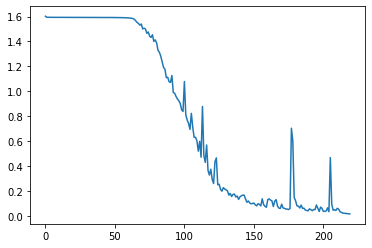

In [100]:
plt.plot(training_losses)

In [95]:
#Training task action
epochs = 200
#set batch size 
batch_size = 40

# Keep track of losses for plotting
testing_losses = []
testing_accuracies = []
testing_losses = []
for i in range(1):
  current_loss = 0
  all_losses = []
  model = TopicModel()
  optimizer = optim.SGD(model.parameters(), lr=lr)

  idxs = torch.randperm(len(task_action_text_commands))
  text_commands = task_action_text_commands[idxs]
  labels = task_action_labels[idxs]

  training_text_commands,testing_text_commands = text_commands[:2040], text_commands[2040:2550]
  training_labels, testing_labels = labels[:2040], labels[2040:2550]

  #set number of batches
  training_num_batches = int(len(training_text_commands)/batch_size) 

  #reshape text commands and labels to fit training
  training_text_commands = torch.reshape(training_text_commands,(training_num_batches,batch_size,task_action_max_len,300))
  training_labels = torch.reshape(training_labels,(training_num_batches,batch_size,num_topics))
  testing_labels = torch.reshape(testing_labels,(1,testing_labels.shape[0],testing_labels.shape[1]))
  training_losses = []
  for iter in range(1, epochs + 1):
    for batch_iter in range(training_num_batches):
      text_batch, label_batch = training_text_commands[batch_iter], training_labels[batch_iter]
      output, loss = train(label_batch, text_batch)
      current_loss += loss

    training_losses.append(current_loss/training_num_batches)

    # Add current loss avg to list of losses
    if iter == epochs:
      testing_accuracy, testing_loss = test(model, testing_labels, testing_text_commands)
      testing_accuracies.append(testing_accuracy)
      testing_losses.append(testing_loss.item())
      all_losses.append(current_loss / training_num_batches)
    
    current_loss = 0

In [96]:
sum(testing_accuracies)/len(testing_accuracies)

0.903921568627451

In [97]:
sum(testing_losses)/len(testing_losses)

0.40419402718544006

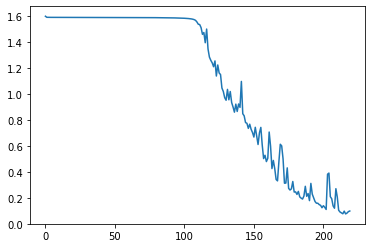

In [93]:
plt.plot(training_losses)